<a href="https://colab.research.google.com/github/Maraudier/tkfruit/blob/team-model-testing/Inceptionv3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Obtain your Kaggle token. 
token = {"username":"lightshift","key":"b7ab47deb22bd26d7cb071a39c232d1c"}
#some Colab and Kaggle set up
from google.colab import files
!pip install kaggle
!mkdir .kaggle
!mkdir ~/.kaggle
import json 
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
#Obtain Data set
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification -p /content
!unzip \*.zip
!rm -rf /content/dataset/dataset/
!ls

- path is now set to: {/content}
100% 3.57G/3.58G [01:10<00:00, 41.8MB/s]
100% 3.58G/3.58G [01:10<00:00, 54.4MB/s]
Archive:  fruits-fresh-and-rotten-for-classification.zip
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.15 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.22 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.41 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.02.43 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.03.40 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.04.16 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.04.24 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.05.34 PM.png  
  inflating: dataset/datase

In [2]:
#Use Auto tune?
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
from tensorflow.keras import datasets, layers, models
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image

train_dir = pathlib.Path('dataset/train')
test_dir = pathlib.Path('dataset/test')

TensorFlow 2.x selected.


In [0]:
train_images_total = len(list(train_dir.glob('*/*.png'))) 
test_images_total = len(list(test_dir.glob('*/*.png')))
total_images = train_images_total + test_images_total
#Pre-set some hyper parameters
#BATCH_SIZE 
#How many images we send in each time for training before starting again
#Smaller batch = Less Accuracy and under fitting. Too high a batch and over fit 
BATCH_SIZE = 128
IMG_W = 299
IMG_H = 299
EPOCH_STEPS = np.ceil(total_images/BATCH_SIZE)

In [4]:
#normalize test images
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#normalize and generate additional train data
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=.19,
                                                                  zoom_range=.19,
                                                                  horizontal_flip=True)
train_data_gen = train_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_H, IMG_W),
                                                     class_mode="sparse")
test_data_gen = test_generator.flow_from_directory(directory=str(test_dir),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   target_size=(IMG_H, IMG_W),
                                                   class_mode="sparse")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [5]:
model = tf.keras.applications.InceptionV3(include_top=True, 
                                          weights='imagenet', 
                                          input_tensor=None, 
                                          input_shape=None, 
                                          pooling='max', 
                                          classes=1000)
new = model.input
hidden_layer = model.layers[-1].output

collected_model = tf.keras.Model(new, hidden_layer)
collected_model.summary()

96116736/96112376 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [6]:
collected_model.compile(optimizer="adam",
                        loss="sparse_categorical_crossentropy",
                        metrics=['sparse_categorical_accuracy'])
history = collected_model.fit_generator(
    train_data_gen,
    epochs=30,
    validation_data=test_data_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 86 steps, validate for 22 steps
Epoch 1/30
86/86 [==============================] - 227s 3s/step - loss: 0.2599 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.1702 - val_sparse_categorical_accuracy: 0.5723
Epoch 2/30
86/86 [==============================] - 219s 3s/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9888 - val_loss: 2.0958 - val_sparse_categorical_accuracy: 0.5945
Epoch 3/30
86/86 [==============================] - 218s 3s/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.5289 - val_sparse_categorical_accuracy: 0.8076
Epoch 4/30
86/86 [==============================] - 218s 3s/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.1524 - val_sparse_categorical_accuracy: 0.9540
Epoch 5/30
86/86 [==============================] - 218s 3s/step - loss: 0.0145 - sparse_categorical_accuracy: 0.995

  ...
    to  
  ['...']
22/22 - 12s - loss: 7.4596e-06 - sparse_categorical_accuracy: 1.0000


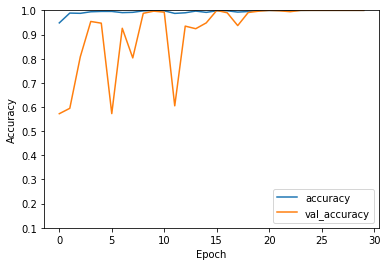

In [9]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
test_loss, test_acc = collected_model.evaluate(test_data_gen, verbose=2)

In [0]:
print("Accuracy", collected_model['accuracy'])
print("Val_Accuracy", collected_model['val_accuracy'])
print("Loss", collected_model['loss'])

In [0]:
import base64
#Will's save model
def save_model_signed(model, path):
  @tf.function(input_signature=[tf.TensorSpec(shape=[None,], dtype=tf.string)])
  def preprocess_and_evaluate(b64_img):
    img = tf.image.decode_image(b64_img[0], dtype=tf.uint8)
    img.set_shape((None, None, 3))
    img = tf.image.resize(img,[128,128])
    img = tf.reshape(img,(-1,128,128,3))
    img = tf.cast(img, dtype=tf.float32)/255
    return model(img)

  tf.saved_model.save(model, path, signatures=preprocess_and_evaluate)

In [0]:
#save model, in current directory
save_model_signed(collected_model,'')